# Analysis:

In [560]:
!pwd

/Users/yuh13/Desktop/code/awesome_project/MAIN DATA/recipe of main_data


### 1) Creating Main Data Set for Analysis

In [584]:
#Import dependencies and raw data files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import ipywidgets as widgets
from IPython.display import display
from bokeh.io import output_notebook, push_notebook
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool,PanTool,WheelZoomTool,BoxZoomTool,ResetTool,UndoTool,RedoTool, Range1d
# import plotly as py
import plotly as py
import plotly.tools as tls
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import folium
from config import gkey


py.offline.init_notebook_mode(connected=True)


#Read raw data sets
data1 = pd.read_csv("Inpatient_Prospective_Payment_System.csv",encoding='mac_roman') #core raw data set
data2 = pd.read_csv("bedsLatLong.csv",encoding='mac_roman') #grabbing bed count only
data3 = pd.read_csv("ratingsAndOwnership.csv",encoding='mac_roman') #grabbing ratings and ownership type only


In [440]:
#Core data set, grabbing keys of interest
data1 = data1[['Provider Id', 'Provider Name', 'Provider Street Address', 
               'Provider City', 'Provider State', 'Provider Zip Code',     
               ' Average Total Payments ', 'Average Medicare Payments', ' Average Covered Charges ']]

#Beds data set, grabbing keys of interest
data2 = data2[[ 'ID', 'NAME',  'BEDS']]
data2 = data2.rename(columns={'ID': 'Provider Id', 'NAME':'Provider Name'})

#Ratings and Ownership dataset, grabbing keys of interest
data3 = data3[['Provider ID', 'Hospital Type', 'Hospital Ownership',
       'Hospital overall rating']]
data3 = data3.rename(columns={'Provider ID': 'Provider Id'})


In [441]:
#Merging datasets by Provider Id and Provider Name
main = pd.merge(data1,data3, on = 'Provider Id', how = 'outer')
main = pd.merge(main,data2, on = 'Provider Name', how = 'outer')

In [442]:
#Removing duplicate keys for Provider Id and renaming
main = main[['Provider Id_x', 'Provider Name', 'Provider Street Address',
       'Provider City', 'Provider State', 'Provider Zip Code',
        ' Average Covered Charges ',' Average Total Payments ', 
        'Average Medicare Payments','Hospital Type', 'Hospital Ownership', 
        'Hospital overall rating', 'BEDS']]
main = main.rename(columns={'Provider Id_x': 'Provider Id'})

In [443]:
#grouping catagory into Hospital ownership: Voluntary(non-profit), Government, Individual business
main["Hospital Ownership"] = main["Hospital Ownership"].replace({
    
    'Voluntary non-profit - Private':'Voluntary(non-profit)',
    'Voluntary non-profit - Church':'Voluntary(non-profit)',
    'Voluntary non-profit - Other':'Voluntary(non-profit)', 
    
    'Government - Hospital District or Authority': 'Government',
    'Government - State': 'Government',
    'Government - Local': 'Government',
    'Government - Federal': 'Government',
    
    'Proprietary': 'Individual Business',
     'Physician': 'Individual Business'})

In [444]:
#Cleaning by droping redundant rows and rows with empty fields
main= main.drop_duplicates()
main = main.dropna(how = "any") 
main = main[main['Hospital overall rating'] != "Not Available"]
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122360 entries, 0 to 184196
Data columns (total 13 columns):
Provider Id                  122360 non-null float64
Provider Name                122360 non-null object
Provider Street Address      122360 non-null object
Provider City                122360 non-null object
Provider State               122360 non-null object
Provider Zip Code            122360 non-null float64
 Average Covered Charges     122360 non-null object
 Average Total Payments      122360 non-null object
Average Medicare Payments    122360 non-null object
Hospital Type                122360 non-null object
Hospital Ownership           122360 non-null object
Hospital overall rating      122360 non-null object
BEDS                         122360 non-null float64
dtypes: float64(3), object(10)
memory usage: 13.1+ MB


In [445]:
#Converting payment strings to floats
main[' Average Total Payments '] = main[' Average Total Payments '].str.split('$').apply(lambda x: x[-1])
main['Average Medicare Payments'] = main['Average Medicare Payments'].str.split('$').apply(lambda x: x[-1])
main[' Average Covered Charges '] = main[' Average Covered Charges '].str.split('$').apply(lambda x: x[-1])
main[' Average Total Payments '] = pd.to_numeric(main[' Average Total Payments '])
main['Average Medicare Payments'] = pd.to_numeric(main['Average Medicare Payments'])
main[' Average Covered Charges '] = pd.to_numeric(main[' Average Covered Charges '])
main['Hospital overall rating'] = pd.to_numeric(main['Hospital overall rating'])

main['Provider Id'] = main['Provider Id'].astype(np.int64)


In [446]:
#Adding a new "Cost" key
main['Cost'] = main[' Average Total Payments '] - main['Average Medicare Payments']

In [608]:
#Main Dataframe
print(main.shape)
main.to_csv("main_data.csv")
main.head(3)

(122360, 14)


,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Average Covered Charges,Average Total Payments,Average Medicare Payments,Hospital Type,Hospital Ownership,Hospital overall rating,BEDS,Cost
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301.0,32963.07,5777.24,4763.73,Acute Care Hospitals,Government,3,420.0,1013.51
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301.0,20312.78,4894.76,3865.50,Acute Care Hospitals,Government,3,420.0,1029.26
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301.0,38820.39,10260.21,9167.08,Acute Care Hospitals,Government,3,420.0,1093.13


### Create dataset that averages all charges by each Hospital

In [609]:
#Create subset of keys
main_less = main.drop([' Average Covered Charges ', ' Average Total Payments ', 'Average Medicare Payments', 'Cost', 'Provider Zip Code', 'BEDS', 'Hospital overall rating'], axis=1)

In [610]:
#Group all providers to average all charges/costs irrespective of treatment charges
main_mean = main.groupby('Provider Id').mean()
main_mean = pd.DataFrame(main_mean).reset_index(inplace=False)
#Merge averaged costs with 'main_data' and drop all duplicates
main_mean = main_mean.merge(main_less, on='Provider Id', how='inner', copy=False)
print(len(main_mean))
main_mean = main_mean.drop_duplicates(keep = 'first').reset_index(inplace=False)
main_mean = main_mean.drop(['index'], axis=1)
print(len(main_mean))

122360
1983


### Perform Google API: Geocode search to populate latitude and longitude for each hospital
##### Do not uncomment unless you want to re-run API calls

In [611]:
#Join address and city and state
address = []

def get_address(index):
    target = main_mean['Provider Street Address'][index] + ", " + main_mean['Provider City'][index] + ", " + main_mean['Provider State'][index]
    return target
for i in range(len(main_mean)):
    address.append(get_address(i))

In [316]:
lat = []
lng = []
counter = 0

#Return json response
for target_address in address:
    params = {"address": target_address, "key": gkey}
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    response = requests.get(base_url, params=params).json()
    #traverse response to find lon/lat
    try:
        lat.append(response['results'][0]['geometry']['location']['lat'])
        lng.append(response['results'][0]['geometry']['location']['lng'])
    except Exception:
        lat.append(0)
        lng.append(0)
    counter = counter + 1
    print(f'{counter} of {len(main_mean)} completed')


1 of 1983 completed
2 of 1983 completed
3 of 1983 completed
4 of 1983 completed
5 of 1983 completed
6 of 1983 completed
7 of 1983 completed
8 of 1983 completed
9 of 1983 completed
10 of 1983 completed
11 of 1983 completed
12 of 1983 completed
13 of 1983 completed
14 of 1983 completed
15 of 1983 completed
16 of 1983 completed
17 of 1983 completed
18 of 1983 completed
19 of 1983 completed
20 of 1983 completed
21 of 1983 completed
22 of 1983 completed
23 of 1983 completed
24 of 1983 completed
25 of 1983 completed
26 of 1983 completed
27 of 1983 completed
28 of 1983 completed
29 of 1983 completed
30 of 1983 completed
31 of 1983 completed
32 of 1983 completed
33 of 1983 completed
34 of 1983 completed
35 of 1983 completed
36 of 1983 completed
37 of 1983 completed
38 of 1983 completed
39 of 1983 completed
40 of 1983 completed
41 of 1983 completed
42 of 1983 completed
43 of 1983 completed
44 of 1983 completed
45 of 1983 completed
46 of 1983 completed
47 of 1983 completed
48 of 1983 completed
4

379 of 1983 completed
380 of 1983 completed
381 of 1983 completed
382 of 1983 completed
383 of 1983 completed
384 of 1983 completed
385 of 1983 completed
386 of 1983 completed
387 of 1983 completed
388 of 1983 completed
389 of 1983 completed
390 of 1983 completed
391 of 1983 completed
392 of 1983 completed
393 of 1983 completed
394 of 1983 completed
395 of 1983 completed
396 of 1983 completed
397 of 1983 completed
398 of 1983 completed
399 of 1983 completed
400 of 1983 completed
401 of 1983 completed
402 of 1983 completed
403 of 1983 completed
404 of 1983 completed
405 of 1983 completed
406 of 1983 completed
407 of 1983 completed
408 of 1983 completed
409 of 1983 completed
410 of 1983 completed
411 of 1983 completed
412 of 1983 completed
413 of 1983 completed
414 of 1983 completed
415 of 1983 completed
416 of 1983 completed
417 of 1983 completed
418 of 1983 completed
419 of 1983 completed
420 of 1983 completed
421 of 1983 completed
422 of 1983 completed
423 of 1983 completed
424 of 198

752 of 1983 completed
753 of 1983 completed
754 of 1983 completed
755 of 1983 completed
756 of 1983 completed
757 of 1983 completed
758 of 1983 completed
759 of 1983 completed
760 of 1983 completed
761 of 1983 completed
762 of 1983 completed
763 of 1983 completed
764 of 1983 completed
765 of 1983 completed
766 of 1983 completed
767 of 1983 completed
768 of 1983 completed
769 of 1983 completed
770 of 1983 completed
771 of 1983 completed
772 of 1983 completed
773 of 1983 completed
774 of 1983 completed
775 of 1983 completed
776 of 1983 completed
777 of 1983 completed
778 of 1983 completed
779 of 1983 completed
780 of 1983 completed
781 of 1983 completed
782 of 1983 completed
783 of 1983 completed
784 of 1983 completed
785 of 1983 completed
786 of 1983 completed
787 of 1983 completed
788 of 1983 completed
789 of 1983 completed
790 of 1983 completed
791 of 1983 completed
792 of 1983 completed
793 of 1983 completed
794 of 1983 completed
795 of 1983 completed
796 of 1983 completed
797 of 198

1119 of 1983 completed
1120 of 1983 completed
1121 of 1983 completed
1122 of 1983 completed
1123 of 1983 completed
1124 of 1983 completed
1125 of 1983 completed
1126 of 1983 completed
1127 of 1983 completed
1128 of 1983 completed
1129 of 1983 completed
1130 of 1983 completed
1131 of 1983 completed
1132 of 1983 completed
1133 of 1983 completed
1134 of 1983 completed
1135 of 1983 completed
1136 of 1983 completed
1137 of 1983 completed
1138 of 1983 completed
1139 of 1983 completed
1140 of 1983 completed
1141 of 1983 completed
1142 of 1983 completed
1143 of 1983 completed
1144 of 1983 completed
1145 of 1983 completed
1146 of 1983 completed
1147 of 1983 completed
1148 of 1983 completed
1149 of 1983 completed
1150 of 1983 completed
1151 of 1983 completed
1152 of 1983 completed
1153 of 1983 completed
1154 of 1983 completed
1155 of 1983 completed
1156 of 1983 completed
1157 of 1983 completed
1158 of 1983 completed
1159 of 1983 completed
1160 of 1983 completed
1161 of 1983 completed
1162 of 198

1476 of 1983 completed
1477 of 1983 completed
1478 of 1983 completed
1479 of 1983 completed
1480 of 1983 completed
1481 of 1983 completed
1482 of 1983 completed
1483 of 1983 completed
1484 of 1983 completed
1485 of 1983 completed
1486 of 1983 completed
1487 of 1983 completed
1488 of 1983 completed
1489 of 1983 completed
1490 of 1983 completed
1491 of 1983 completed
1492 of 1983 completed
1493 of 1983 completed
1494 of 1983 completed
1495 of 1983 completed
1496 of 1983 completed
1497 of 1983 completed
1498 of 1983 completed
1499 of 1983 completed
1500 of 1983 completed
1501 of 1983 completed
1502 of 1983 completed
1503 of 1983 completed
1504 of 1983 completed
1505 of 1983 completed
1506 of 1983 completed
1507 of 1983 completed
1508 of 1983 completed
1509 of 1983 completed
1510 of 1983 completed
1511 of 1983 completed
1512 of 1983 completed
1513 of 1983 completed
1514 of 1983 completed
1515 of 1983 completed
1516 of 1983 completed
1517 of 1983 completed
1518 of 1983 completed
1519 of 198

1833 of 1983 completed
1834 of 1983 completed
1835 of 1983 completed
1836 of 1983 completed
1837 of 1983 completed
1838 of 1983 completed
1839 of 1983 completed
1840 of 1983 completed
1841 of 1983 completed
1842 of 1983 completed
1843 of 1983 completed
1844 of 1983 completed
1845 of 1983 completed
1846 of 1983 completed
1847 of 1983 completed
1848 of 1983 completed
1849 of 1983 completed
1850 of 1983 completed
1851 of 1983 completed
1852 of 1983 completed
1853 of 1983 completed
1854 of 1983 completed
1855 of 1983 completed
1856 of 1983 completed
1857 of 1983 completed
1858 of 1983 completed
1859 of 1983 completed
1860 of 1983 completed
1861 of 1983 completed
1862 of 1983 completed
1863 of 1983 completed
1864 of 1983 completed
1865 of 1983 completed
1866 of 1983 completed
1867 of 1983 completed
1868 of 1983 completed
1869 of 1983 completed
1870 of 1983 completed
1871 of 1983 completed
1872 of 1983 completed
1873 of 1983 completed
1874 of 1983 completed
1875 of 1983 completed
1876 of 198

In [612]:
#Add new values to main_mean
main_mean['Location'] = address
main_mean['Latitude'] = lat
main_mean['Longitude'] = lng
main_mean = main_mean[main_mean['Longitude'] != 0]
main_mean.to_csv('main_mean.csv')
print(len(main_mean))
main_mean.head(2)

1973


,Provider Id,Provider Zip Code,Average Covered Charges,Average Total Payments,Average Medicare Payments,Hospital overall rating,BEDS,Cost,Provider Name,Provider Street Address,Provider City,Provider State,Hospital Type,Hospital Ownership,Location,Latitude,Longitude
0,10001,36301.0,35247.028152,8749.025109,7678.214348,3,420.0,1070.810761,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,Acute Care Hospitals,Government,"1108 ROSS CLARK CIRCLE, DOTHAN, AL",31.215884,-85.363008
1,10005,35957.0,16451.092041,6812.131224,5793.631429,2,150.0,1018.499796,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,Acute Care Hospitals,Government,"2505 U S HIGHWAY 431 NORTH, BOAZ, AL",34.221590,-86.160495


### Harry's USA Map: Avg Cost by Hospitals in US

In [613]:
#input into plotly by scattergeo
data = [dict(type="scattergeo", locationmode="USA-states", text = main_mean['Provider Name'] + main_mean['Provider Street Address'], lon = main_mean['Longitude'], lat = main_mean['Latitude'], 
             marker = dict(size=4, autocolorscale=False, colorscale='Portland',
            color = main_mean[' Average Covered Charges '], colorbar = dict(title = 'Avg Cost ($)')))]

In [614]:
layout = dict(title="Avg Cost by Hospitals in US",
              geo = dict(scope='usa',projection = dict(type='albers usa'), 
                         showland=True, landcolor="rgb(250,250,250)"))

In [615]:
fig = dict(data=data, layout=layout)
py.plotly.image.save_as(fig,filename='USA_map_avg_cost.png')
py.plotly.iplot(fig)


### Starting Nami's App for State analysis

In [343]:
def checkDF(df):
    requirements = ['Provider State', 'Cost', 'BEDS', 'Provider Name']
    errorFlag = False
    for req in requirements:
        if not req in df:
            print(f'DF structure error: dataframe must include "{req}". please confirm your dataframe:-(')
            errorFlag = True
            break
    if not errorFlag:
        print('Checks out!')
        return df

In [452]:
df = checkDF(main_mean)
df.columns

Checks out!


Index(['Provider Id', 'Provider Zip Code', ' Average Covered Charges ',
       ' Average Total Payments ', 'Average Medicare Payments',
       'Hospital overall rating', 'BEDS', 'Cost', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Hospital Type', 'Hospital Ownership'],
      dtype='object')

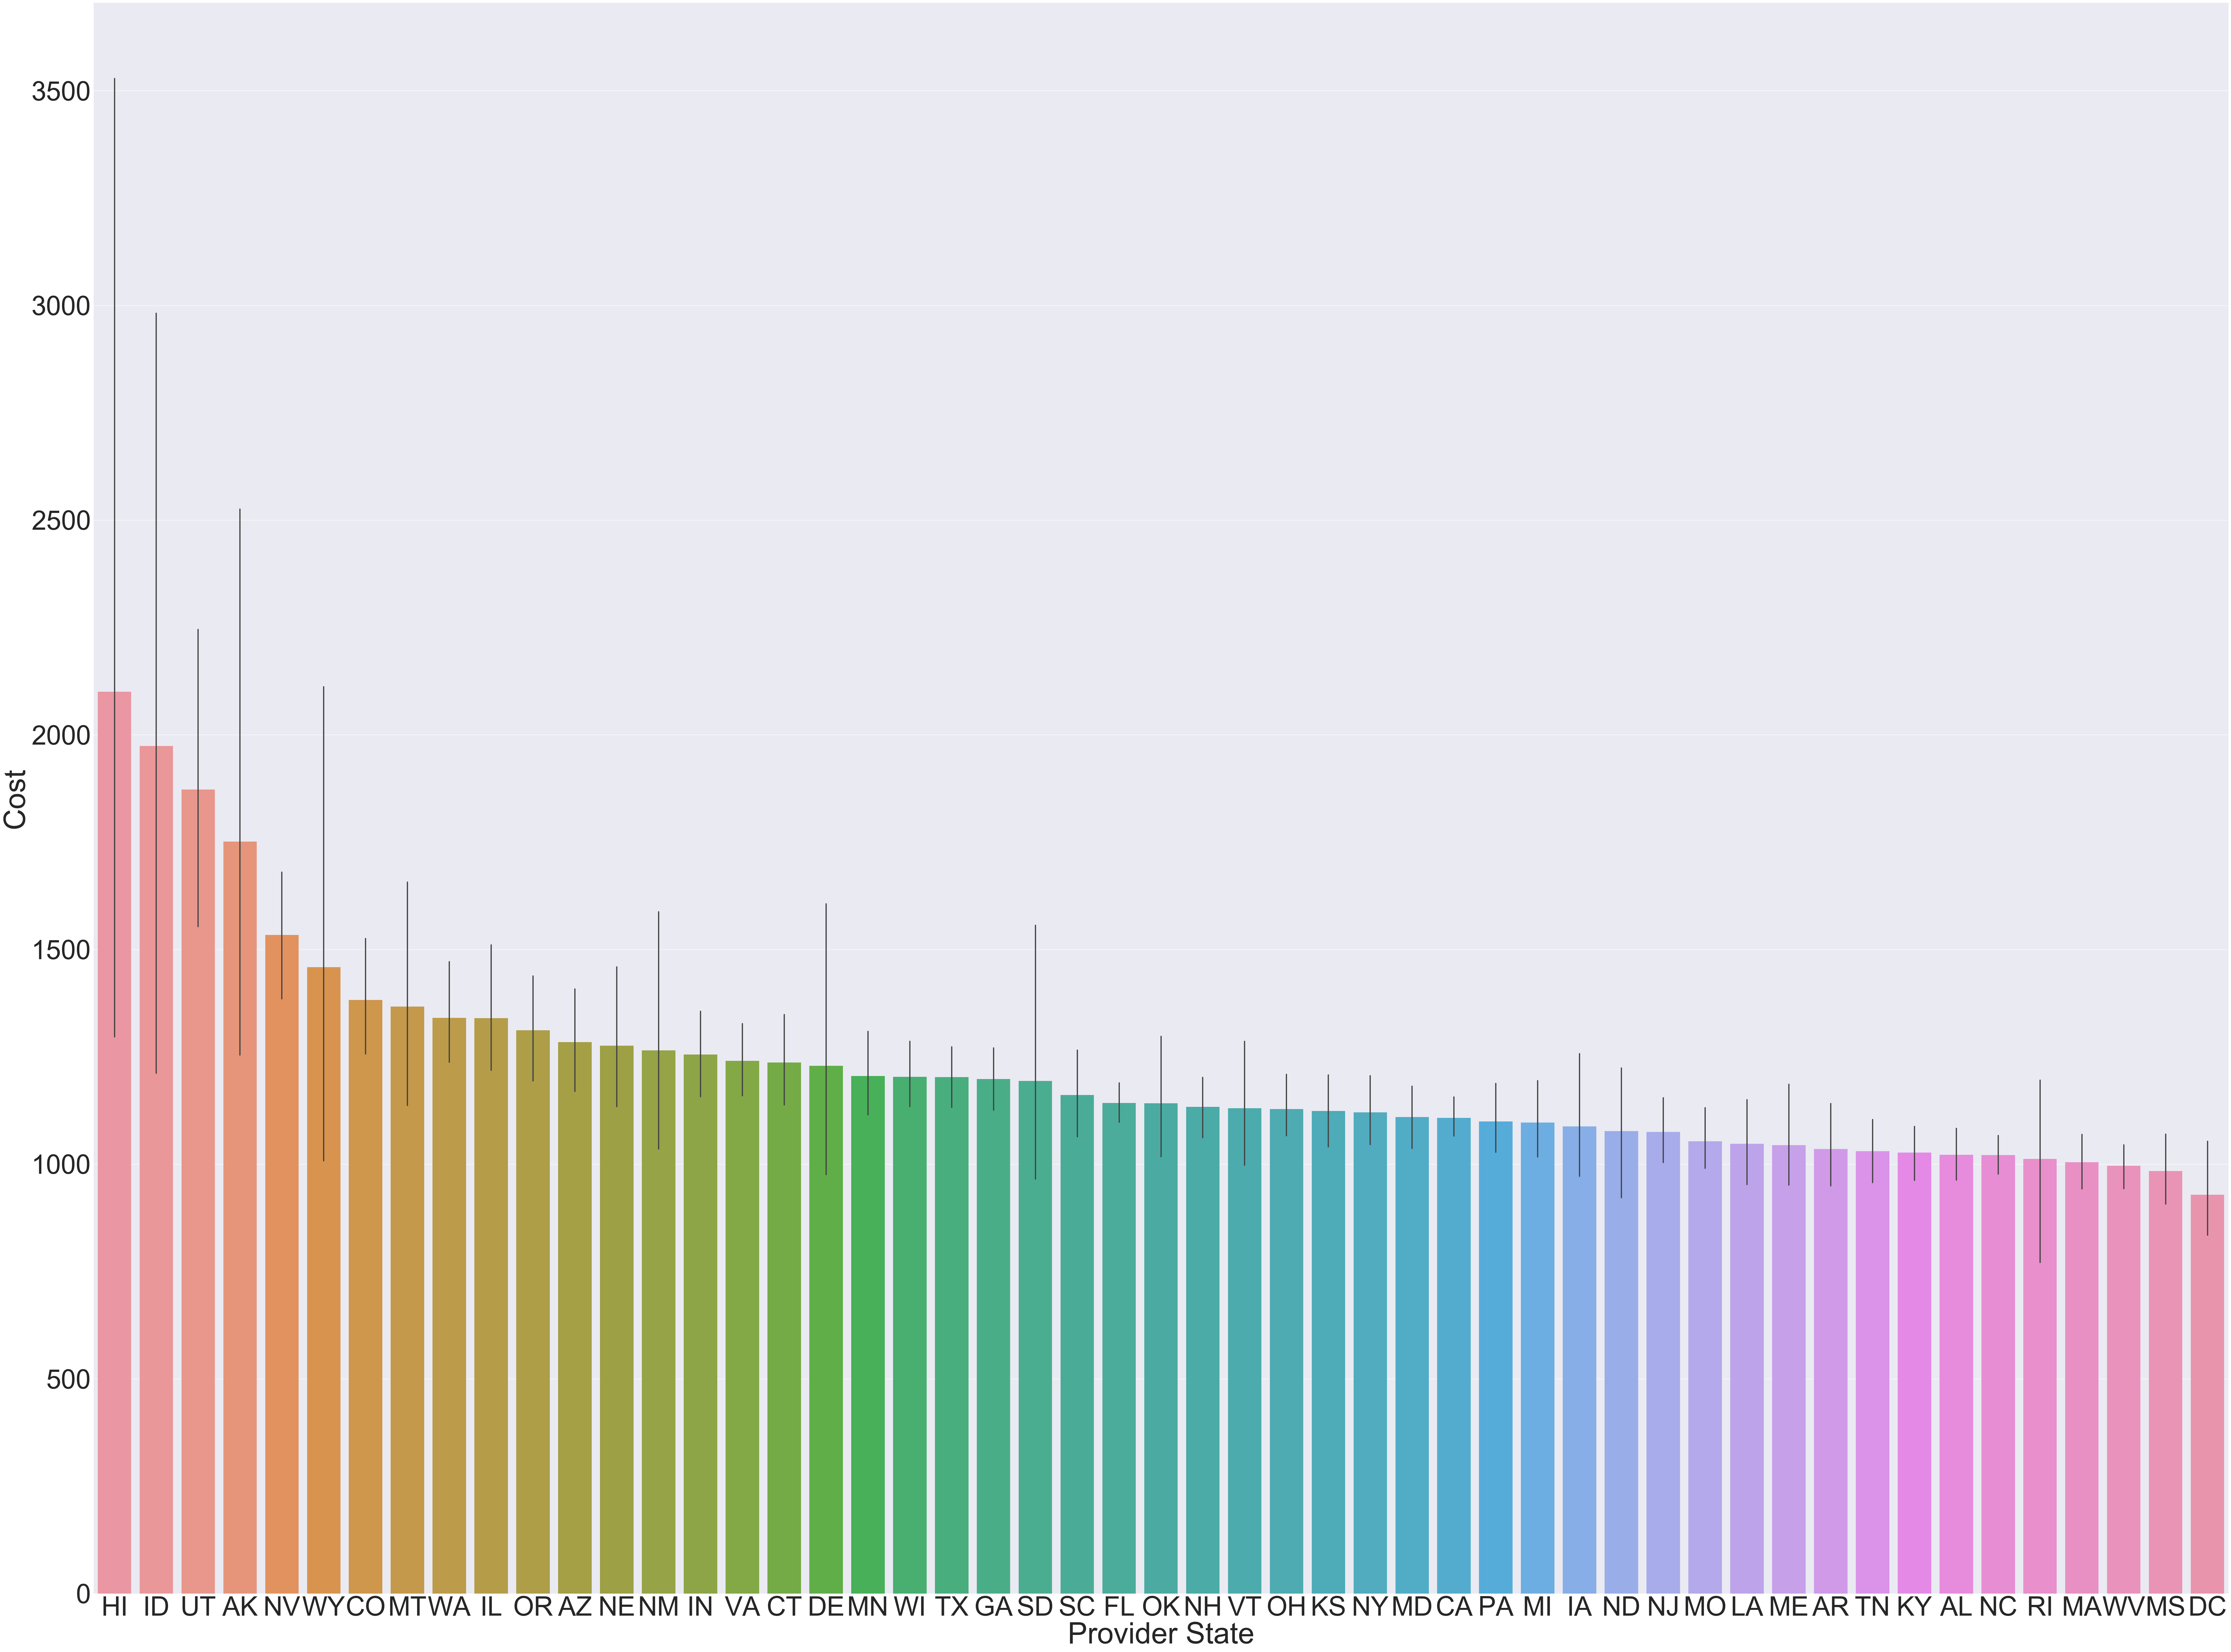

In [617]:
states = df.groupby('Provider State').mean().sort_values(by=['Cost'], ascending=False).index
sns.barplot(x='Provider State', y='Cost', data=df, order=states)
sns.set(rc={'figure.figsize':(100,75)}, font_scale=7)
plt.savefig('state_cost.png')
plt.show()

### Pierre's Bar Chart: State and Ratings

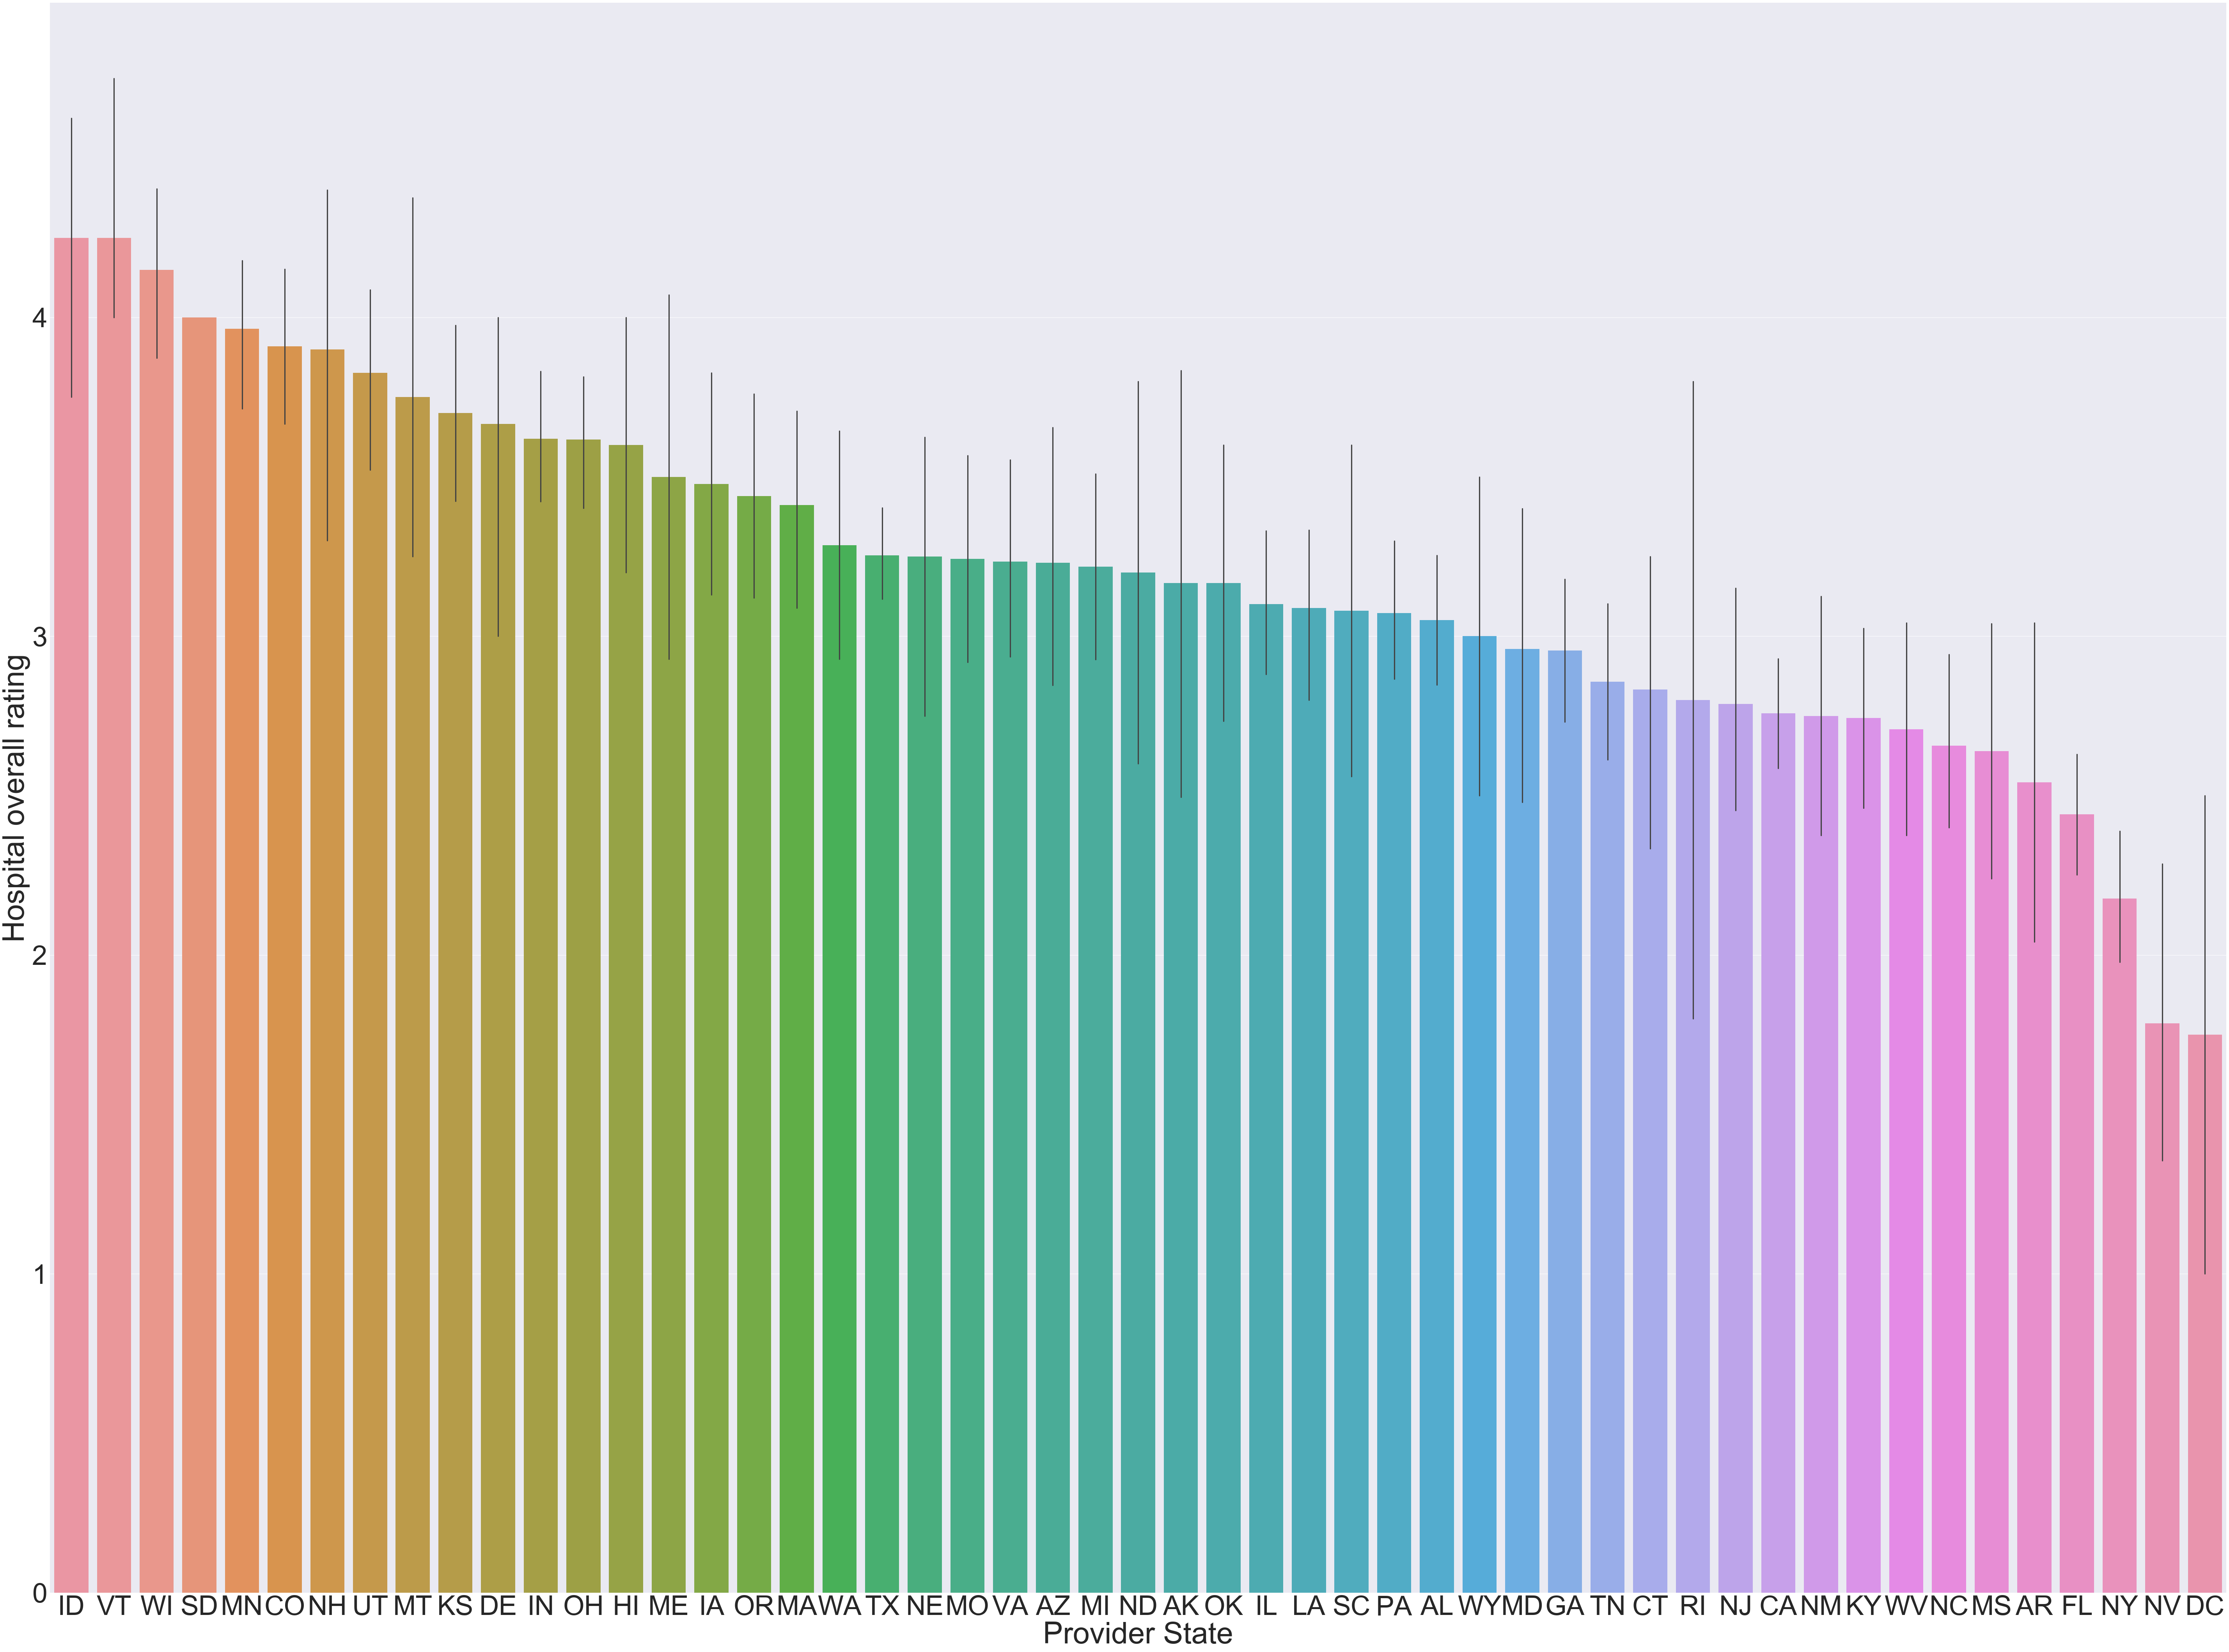

In [519]:
states = df.groupby('Provider State').mean().sort_values(by=['Hospital overall rating'], ascending=False).index
sns.barplot(x='Provider State', y='Hospital overall rating', data=df, order=states)
sns.set(rc={'figure.figsize':(100,75)}, font_scale=7)
plt.savefig('state_rating.png')
plt.show()

In [592]:
# Load the shape of the zone (US states)
# Find the original file here: https://github.com/python-visualization/folium/tree/master/examples/data
state_geo = 'us-states.json'
 
df2 = df[df['BEDS']>0]

# Load the values of each state
state_data = pd.DataFrame()
state_data['State'] = list(df2.groupby('Provider State').mean().index)
state_data['Cost'] = list(df2.groupby('Provider State').mean()['Cost'])
state_data['HospitalCounts'] = list(df2.groupby('Provider State').count()['Cost'])
state_data['Rating'] = list(df2.groupby('Provider State').mean()['Hospital overall rating'])
state_data['BedCounts'] = list(df2.groupby('Provider State').mean()['BEDS'])
# state_data
# threshold_scale = split_six(state_data['Cost'])
colors = ['#1a9850', '#91cf60', '#fc8d59', '#d9ef8b', '#ffffbf','#fee08b']



In [619]:
### Choropleth US Map for Hospital Costs
# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)
# step = folium.StepColormap(colors, vmin=921, vmax=2022, index=[921, 1105, 1288, 1472, 1655,1838,2022])
# step = folium.StepColormap(colors)

# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=state_data,
 columns=['State', 'Cost'],
 key_on='feature.id',
 fill_color='RdYlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Cost ($)'
)
folium.LayerControl().add_to(m)

m

In [620]:
### Choropleth US Map for Hospital Count
# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)

# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=state_data,
 columns=['State', 'HospitalCounts'],
 key_on='feature.id',
 fill_color='RdYlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Hospital Count'
)
folium.LayerControl().add_to(m)

m

In [621]:
### Choropleth US Map for Hospital Ratings

# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)

# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=state_data,
 columns=['State', 'Rating'],
 key_on='feature.id',
 fill_color='RdYlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Rating'
)
folium.LayerControl().add_to(m)

m

In [622]:
### Chloropleth US Map for Hospital Size

# Initialize the map:
m = folium.Map(location=[37, -102], zoom_start=5)

# Add the color for the chloropleth:
m.choropleth(
 geo_data=state_geo,
 name='choropleth',
 data=state_data,
 columns=['State', 'BedCounts'],
 key_on='feature.id',
 fill_color='RdYlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Hospital Size'
)
folium.LayerControl().add_to(m)

m

In [623]:
def showPlot(df, state, rating=[1,2,3,4,5]):
    if not state in list(df['Provider State']):
        print('your state input might be wrong. please check your input!')
    elif not isinstance(rating, list) or len(rating)==0:
        print('rating must be a list contains more than one numeric element. please check your input!')
    else:
        dfbyState = df[df['Provider State'] == state]
        #dfbyState_Rating = dfbyState[dfbyState["Hospital overall rating"].isin(rating)]
        sns.lmplot(x='Cost', y="BEDS", hue="Hospital overall rating", data=dfbyState, fit_reg=False, legend=True, size = 15, scatter_kws={'alpha':0.9})
        sns.set(rc={'figure.figsize':(2,1)}, font_scale=1)
        plt.ylim(0,)
        plt.xlim(0,4000)
        plt.title(f'Cost-Size relationship in {state}')
#         plt.savefig(f'cost_size_rating_in{state}.png')
        plt.show()

In [624]:
def f(STATE):
    showPlot(df,STATE)
states = df.groupby('Provider State').mean().index
widgets.interact(f, STATE=states);

A Jupyter Widget

In [625]:
hover = HoverTool(tooltips=[
    ("name:", "@prov"),
    ("cost:", "$x"),
    ("size:", "$y")    
])
pan = PanTool()
box = BoxZoomTool()
undo = UndoTool() 
redo = RedoTool()
reset = ResetTool()

# drop data that 'BEDS' > 0
df_hasbeds = df[df['BEDS'] > 0]
states = df_hasbeds.groupby('Provider State').mean().index
d = widgets.Dropdown(options=states, value='AK')
exg_r = []

def initialize_source():
    return ColumnDataSource(data=dict(x=[],y=[],prov=[]))

def initialize_figure(title='Cost-Size relationship', tools=[hover,box,pan,undo,redo,reset], plot_width=640, plot_height=400):
        fig = figure(title=title, tools=tools, plot_width=plot_width, plot_height=plot_height)
        x = np.array([])
        y = np.array([])
        fig.scatter(x, y)     
        return fig
        
# Event handler
def on_value_change(change):
    print('on_val_ch: ' + str(len(exg_r)))
    for r in exg_r:
        if r.visible:
            r.visible=False
    
#     r = fig.line("x", "y", source=initialize_source(), legend=change.new)
#     r.visible=False
#     print(change.new)
    new_dfbyState = df_hasbeds[df_hasbeds['Provider State'] == change.new]
    overlayPlot(new_dfbyState, change.new, [np.random.randint(1,3)])
#     for i in [1,2,3,4,5]:
#         df_State_Rating = new_dfbyState[new_dfbyState["Hospital overall rating"].isin([i])]
#         x = df_State_Rating['Cost']
#         y = df_State_Rating['BEDS']
#         provider = df_State_Rating['Provider name']
#         source = ColumnDataSource(data=dict(x=x,y=y,prov=provider))
#         r = fig.scatter("x", "y", source=source, color = colors[i-1], legend=str(i))
#         push_notebook(handle=t)
#     print(new_dfbyState)
#     new_dfbyState_Rating = new_dfbyState[new_dfbyState["Hospital overall rating"].isin([1,2,3,4,5])]
#     x=new_dfbyState_Rating['Cost']
#     y=new_dfbyState_Rating['BEDS']
#     provider=new_dfbyState_Rating['Provider name'] 
#     source.data=dict(x=x,y=y,desc=provider)
#     t = show(f, notebook_handle=True)
    t = show(fig, notebook_handle=True)
    
    push_notebook(handle=t)
    
def overlayPlot(df_State, state, ratings):
    colors = ['#d7191c', '#fdae61', '#e0e03e', '#a6d96a', '#1a9641']
    if not isinstance(ratings, list) or len(ratings)==0:
        print('rating must be a list contains more than one numeric element. please check your input!')
    else:
        for i in ratings:
            df_State_Rating = df_State[df_State["Hospital overall rating"].isin([i])]
            x = df_State_Rating['Cost']
            y = df_State_Rating['BEDS']
            provider = df_State_Rating['Provider Name']
            source = ColumnDataSource(data=dict(x=x,y=y,prov=provider))
            r = fig.scatter("x", "y", source=source, color = colors[i-1], legend= 'Rating: ' + str(i))
            r.name= f'Rating: {i} --- {state}'
            exg_r.append(r)
    
    for r in exg_r:
        print(f'{r.name}, {r.visible}')   

d.observe(on_value_change, names='value')


target_state = 'CA'
fig = figure(width=640, height=400, tools=[hover,box,pan,undo,redo,reset], title=f'{target_state} Cost-Size relationship')

dfbyState = df_hasbeds[df_hasbeds['Provider State'] == target_state]

display(d)
overlayPlot(dfbyState, target_state,[1,2,3,4,5])
output_notebook()
fig.xaxis.axis_label = 'Cost'
fig.yaxis.axis_label = 'Size (Bed count)'

t = show(fig, notebook_handle=True)

A Jupyter Widget

Rating: 1 --- CA, True
Rating: 2 --- CA, True
Rating: 3 --- CA, True
Rating: 4 --- CA, True
Rating: 5 --- CA, True


Loading BokehJS ...

### Linda's Scatter Plot --- Ownership vs cost

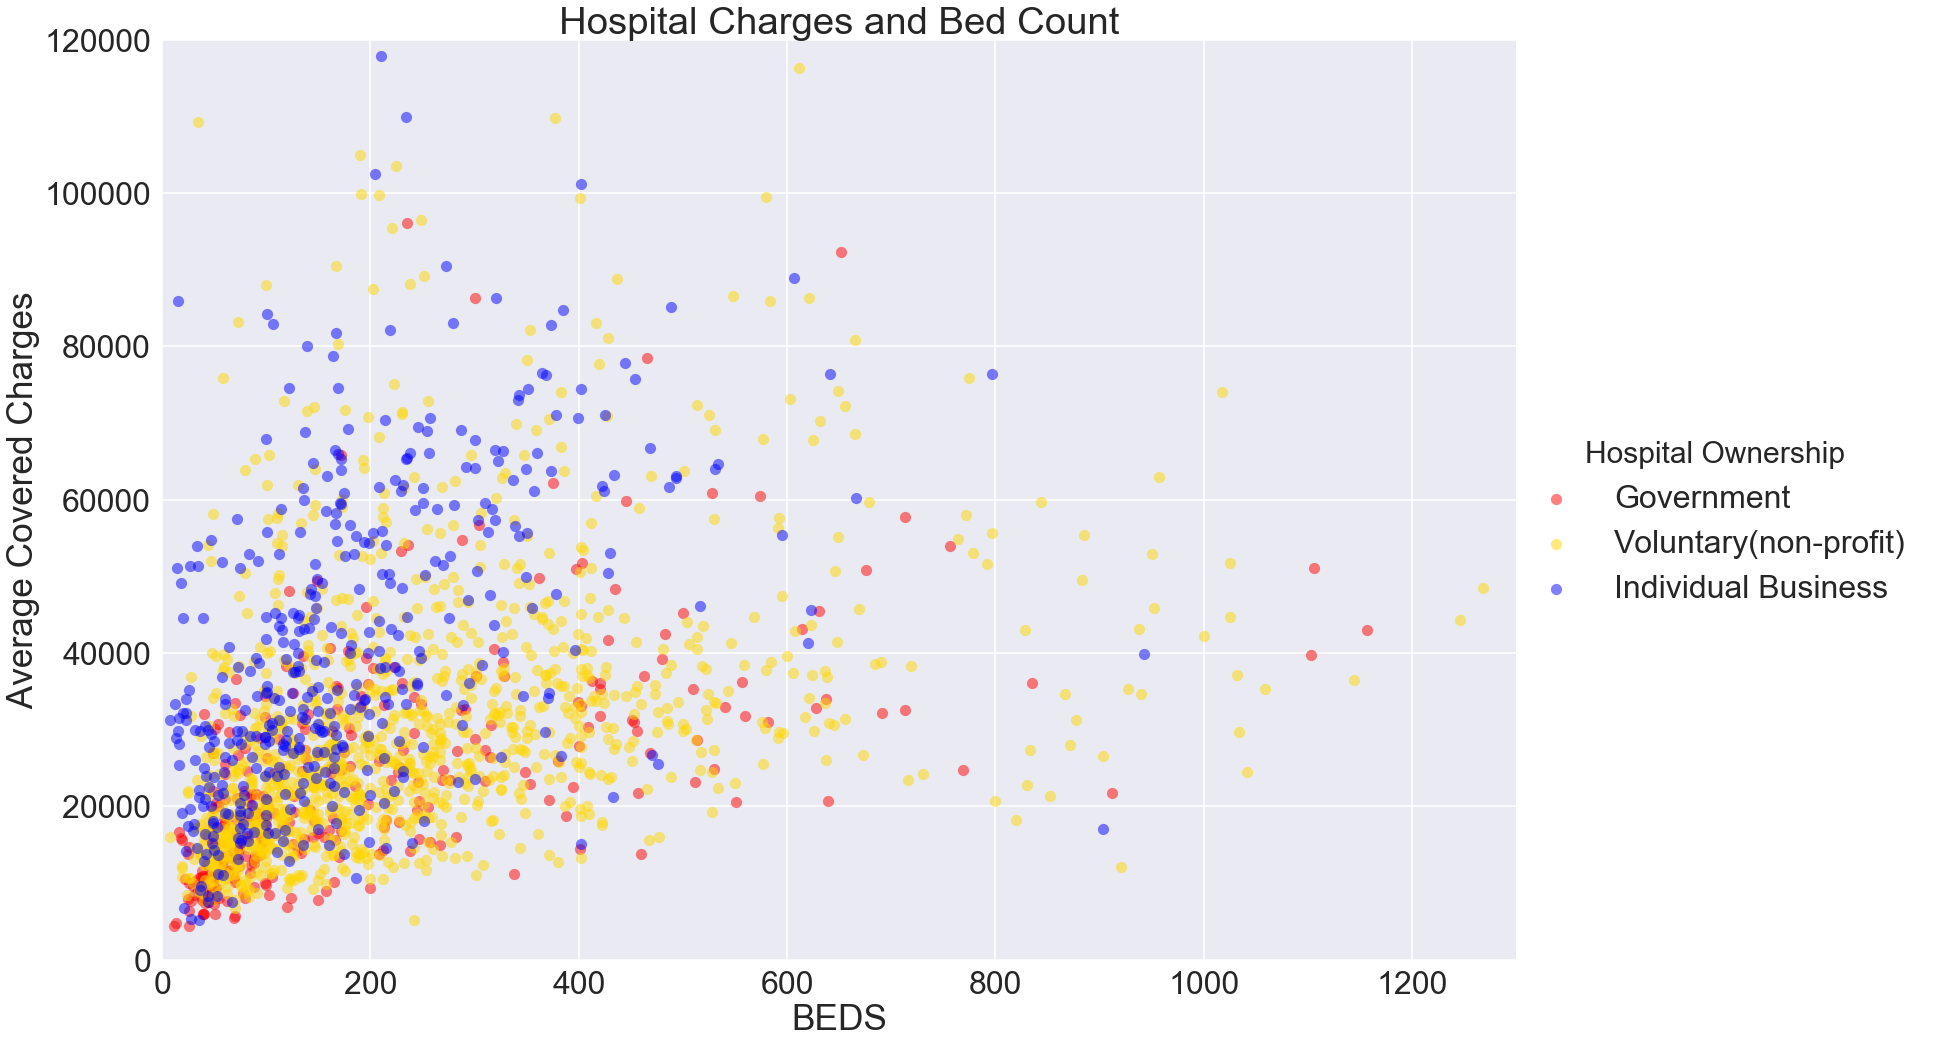

In [543]:

sns.set_context("poster", font_scale = 2)
fig = sns.lmplot(x='BEDS', y=' Average Covered Charges ', hue="Hospital Ownership", data=df, 
           fit_reg=False, scatter_kws={"alpha":0.5},size=15, aspect=1.5, palette=['red','gold','blue'])
plt.xlim(0, 1300)
plt.ylim(0, 120000)
plt.title("Hospital Charges and Bed Count")
plt.figure
plt.savefig("Scatter-Hospital Charges and Bed Count.png")
plt.show()

### Sunny's and Shihong Ownership Analysis

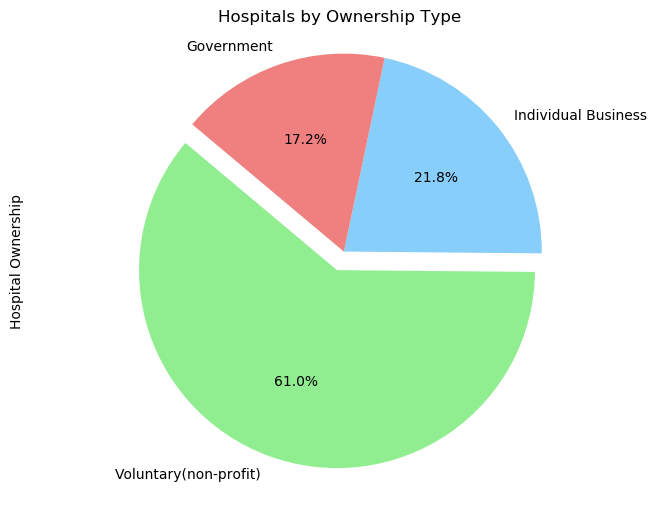

In [548]:
#ploting the percentage of hospitital ownership
plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(8,6))
df["Hospital Ownership"].value_counts(normalize= True).plot(
    kind = "pie",
    explode=[0.1,0,0],
    colors=["lightgreen", "lightskyblue", "lightcoral"],
    autopct="%1.1f%%",
    shadow=False, 
    startangle=140)
plt.title("Hospitals by Ownership Type")
plt.axis("equal") 

plt.savefig("Pie - hospitals by ownership type.png")
plt.show()

In [561]:
#Count for each type of hospital
for each in types:
    print(each)
    print(df['Hospital Ownership'][df['Hospital Ownership'] == each].count())

Government
341
Voluntary(non-profit)
1209
Individual Business
433


In [578]:
# Visualization for cost, rating, capacity for all ownership type 
cost_graph = go.Bar(x =[df['Hospital Ownership'].unique()[0],df['Hospital Ownership'].unique()[2], df['Hospital Ownership'].unique()[1]], 
                    y = df.groupby('Hospital Ownership')['Cost'].mean(),
                   name = "Cost", 
                   marker=dict(
        color='#b2df8a',
        line=dict(
            color='rgb(8,48,107)',
            width=1),
        ))


capa_graph = go.Bar(x =[df['Hospital Ownership'].unique()[0],df['Hospital Ownership'].unique()[2], df['Hospital Ownership'].unique()[1]], 
                    y = df.groupby('Hospital Ownership')['BEDS'].mean(),
                   name = "Capacity",
                   marker=dict(
        color='#a6cee3',
        line=dict(
            color='rgb(8,48,107)',
            width=1),
        ))

rating_graph = go.Bar(x =[df['Hospital Ownership'].unique()[0],df['Hospital Ownership'].unique()[2], df['Hospital Ownership'].unique()[1]], 
                    y = df.groupby('Hospital Ownership')['Hospital overall rating'].mean()*100,
                   name = "Rating",
                   marker=dict(
        color='#1f78b4',
        line=dict(
            color='rgb(8,48,107)',
            width=1),
        ))
data = [cost_graph, capa_graph, rating_graph ]

updatemenus = list([
    dict(type="buttons", x = -0.3,
       
         buttons=list([   
            dict(label = 'Cost Comparison', 
                 method = 'update',  
                 args = [{'visible': [True, False, False]}, 
                         {'title': 'Cost(USD) vs Ownership Type'
                          }]),
            dict(label = 'Capacity Comparison',
                 method = 'update',
                 args = [{'visible': [False, True, False]}, 
                         {'title': 'Capacity(Number of Beds) vs Ownership Type'
                          }]),
            dict(label = 'Rating Comparison',
                 method = 'update', 
                 args = [{'visible': [False, False, True]}, 
                         {'title': 'Rating(Out of 500) vs Ownership Type',
                          }]),
             dict(label = 'Overall Comparison',
                 method = 'update', 
                 args = [{'visible': [True, True, True,True]},  
                         {'title': 'Overall Comparison'
                          }])

       
    
]))])


layout = dict( title ="Overall Comparison", showlegend=True,  width=600,
    height=400,updatemenus=updatemenus)

fig = dict(data=data, layout=layout)
py.plotly.image.save_as(fig,filename='Overall_comparison_types.png')
py.offline.iplot(fig)


In [579]:
#Made this awesome geo scatter plot, WOOOT!
#input into plotly by scattergeo
gov = dict(type="scattergeo", locationmode="USA-states", name = df['Hospital Ownership'].unique()[0],
            text = df['Hospital Ownership'].unique()[0] , 
            lon = df.loc[df['Hospital Ownership']== df['Hospital Ownership'].unique()[0], 'Longitude'],
            lat = df.loc[df['Hospital Ownership']== df['Hospital Ownership'].unique()[0], 'Latitude'], 
             marker = dict(size=6, autocolorscale=True, colorscale='custom-colorscale',
            color = '#d7191c'))

vol = dict(type="scattergeo", locationmode="USA-states", name = df['Hospital Ownership'].unique()[1],
            text = df['Hospital Ownership'].unique()[1] , 
            lon = df.loc[df['Hospital Ownership']== df['Hospital Ownership'].unique()[1],'Longitude'],
            lat = df.loc[df['Hospital Ownership']== df['Hospital Ownership'].unique()[1], 'Latitude'], 
             marker = dict(size=6, autocolorscale=True, colorscale='custom-colorscale',
            color = '#fdae61'))

ind = dict(type="scattergeo", locationmode="USA-states", name = df['Hospital Ownership'].unique()[2],
            text = df['Hospital Ownership'].unique()[2] , 
            lon = df.loc[df['Hospital Ownership']== df['Hospital Ownership'].unique()[2], 'Longitude'],
            lat = df.loc[df['Hospital Ownership']== df['Hospital Ownership'].unique()[2], 'Latitude'], 
             marker = dict(size=6, autocolorscale=True, colorscale='custom-colorscale',
            color = '#2c7bb6'))

data = [gov,vol,ind]

layout = dict(title="Hospital Ownership Distribution in US", showlegend=True,
              geo = dict(scope='usa',projection = dict(type='albers usa'), 
                         showland=True, landcolor="#abd9e9"))

fig = dict(data=data, layout=layout)
py.plotly.image.save_as(fig,filename='USA_map_hospital_types.png')
py.offline.iplot(fig)
